In [4]:
import os, sys
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

# Generating a dataset

In [28]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from PIL import Image

In [29]:

root_dir = Path("fashionmnist_sample")
root_dir.mkdir(exist_ok=True)
classes = [
    "T-shirt", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "AnkleBoot"
]
for cls in classes:
    (root_dir / cls).mkdir(parents=True, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)


samples_per_class = 20
class_counts = {c: 0 for c in range(10)}

print("Saving FashionMNIST samples to structured folder...")
for idx in tqdm(range(len(dataset))):
    img, label = dataset[idx]
    if class_counts[label] >= samples_per_class:
        continue
    class_counts[label] += 1
    # Convert tensor to image
    img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_np.squeeze(), mode='L').convert('RGB')
    save_path = root_dir / classes[label] / f"{idx}.png"
    img_pil.save(save_path)
    if all(v >= samples_per_class for v in class_counts.values()):
        break

print(f"Created sample dataset at: {root_dir}")

Saving FashionMNIST samples to structured folder...


  0%|          | 238/60000 [00:00<02:57, 336.89it/s]

Created sample dataset at: fashionmnist_sample


# Dataloader function

In [30]:
from pathlib import Path
import json
import pandas as pd
from pprint import pprint

from data_utils.loader import (
    load_dataset,
    bulk_extract_metadata,
    summarize_dataset,
    save_labels,
    sample_validation_set
)

# Load dataset
dataset_path = Path("fashionmnist_sample")
records = load_dataset(dataset_path, structured=True)

print(f" Loaded {len(records)} image records")
print("Example record:")
pprint(records[0])

#  Extract metadata
records = bulk_extract_metadata(records, compute_histogram=False)
print("\n Metadata extraction complete.")
print("Sample metadata for first image:")
pprint(records[0]['metadata'])

# Summarize dataset
summary = summarize_dataset(records)
print("\n Dataset Summary:")
print(json.dumps(summary, indent=2))

# Save label CSV
save_labels(records, "fashion_labels.csv")
print("\n Saved labels to fashion_labels.csv")

# Verify
df = pd.read_csv("fashion_labels.csv")
print(df.head())

# Create train/validation split

train_records, val_records = sample_validation_set(records, val_frac=0.2, seed=42)

print(f"\n Train set size: {len(train_records)}")
print(f" Validation set size: {len(val_records)}")

save_labels(train_records, "train_labels.csv")
save_labels(val_records, "val_labels.csv")

print("\n All steps completed successfully!")

 Loaded 200 image records
Example record:
{'id': '88',
 'label': 'AnkleBoot',
 'metadata': {},
 'path': 'fashionmnist_sample/AnkleBoot/88.png'}


100%|██████████| 200/200 [00:00<00:00, 1728.50it/s]


 Metadata extraction complete.
Sample metadata for first image:
{'aspect_ratio': 1.0,
 'height': 64,
 'is_corrupt': False,
 'mean_brightness': 116.57080078125,
 'mode': 'RGB',
 'num_channels': 3,
 'std_brightness': 102.9979940781585,
 'width': 64}

 Dataset Summary:
{
  "num_images": 200,
  "num_labeled": 200,
  "num_unlabeled": 0,
  "class_counts": {
    "AnkleBoot": 20,
    "Bag": 20,
    "Coat": 20,
    "Dress": 20,
    "Pullover": 20,
    "Sandal": 20,
    "Shirt": 20,
    "Sneaker": 20,
    "T-shirt": 20,
    "Trouser": 20
  },
  "resolution_mean": {
    "width": 64.0,
    "height": 64.0
  },
  "resolution_median": {
    "width": 64.0,
    "height": 64.0
  }
}

 Saved labels to fashion_labels.csv
    id                                   path      label
0   88   fashionmnist_sample/AnkleBoot/88.png  AnkleBoot
1   89   fashionmnist_sample/AnkleBoot/89.png  AnkleBoot
2  167  fashionmnist_sample/AnkleBoot/167.png  AnkleBoot
3  198  fashionmnist_sample/AnkleBoot/198.png  AnkleBoot
4  

# Data Quality function

 Scanning images in: fashionmnist_sample
 Analyzed 200 images.
quality_label
good    200
Name: count, dtype: int64
📊 Visualizing sample blurry vs. good quality images...


100%|██████████| 10/10 [00:00<00:00, 3489.15it/s]


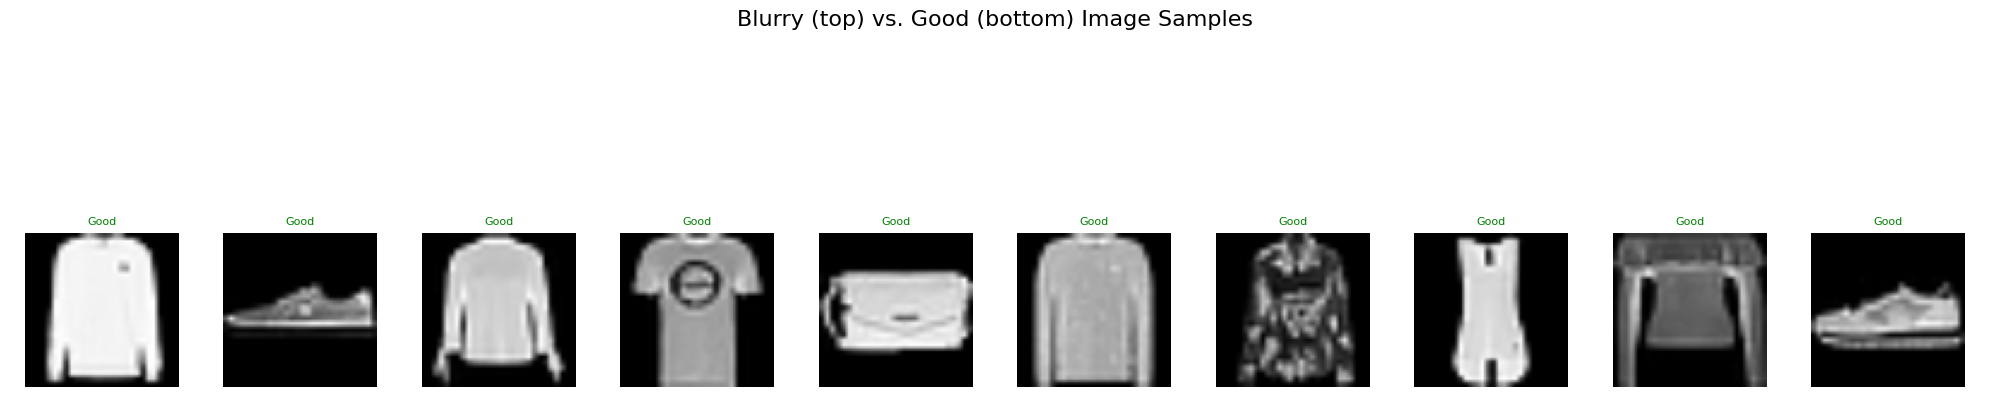

                                path    variance quality_label
0  fashionmnist_sample/Dress/215.png  325.471066          good
1   fashionmnist_sample/Dress/49.png  646.719660          good
2   fashionmnist_sample/Dress/59.png  295.480960          good
3   fashionmnist_sample/Dress/70.png  670.073307          good
4   fashionmnist_sample/Dress/58.png  295.485542          good


In [47]:
from data_utils.quality import assess_image_quality

df = assess_image_quality("fashionmnist_sample", threshold=100.0, visualize=True)
print(df.head())

# Labelling semi supervised datasets

## Simulating a semi supervised dataset from fashion_mnist

In [2]:
from pathlib import Path
import random
from data_utils import labelling   
from importlib import reload
reload(labelling)

dataset_path = Path("fashionmnist_sample")
image_paths, labels = [], []
for class_dir in sorted(dataset_path.iterdir()):
    if class_dir.is_dir():
        for p in class_dir.glob("*.*"):
            if p.suffix.lower() in (".png", ".jpg", ".jpeg"):
                image_paths.append(str(p))
                labels.append(class_dir.name)

In [3]:
import numpy as np
np.random.seed(0)
mask = np.random.rand(len(labels)) < 0.7
partial_labels = [lab if not m else None for lab, m in zip(labels, mask)]

## Run Labeling

In [4]:
results, embeds = labelling.semi_supervised_labeling(
    image_paths=image_paths[:200],          
    partial_labels=partial_labels[:200],
    backbone="resnet18",
    k=5,
    conf_threshold=0.6,
    use_faiss=False,     
    batch_size=8
)

## Evaluate accuracy on masked entries

In [5]:
df_true = pd.DataFrame({"path": image_paths[:200], "true_label": labels[:200], "partial": partial_labels[:200]})
merged = pd.concat([df_true, results[['pred_label', 'final_label', 'confidence']]], axis=1)
mask_unlabeled = merged['partial'].isna()
acc = (merged.loc[mask_unlabeled, 'pred_label'] == merged.loc[mask_unlabeled, 'true_label']).mean()
print("Propagation accuracy on masked samples:", acc)
print(merged.head())


Propagation accuracy on masked samples: 0.6164383561643836
                                    path true_label    partial pred_label  \
0   fashionmnist_sample/AnkleBoot/88.png  AnkleBoot       None  AnkleBoot   
1   fashionmnist_sample/AnkleBoot/89.png  AnkleBoot  AnkleBoot  AnkleBoot   
2  fashionmnist_sample/AnkleBoot/167.png  AnkleBoot       None  AnkleBoot   
3  fashionmnist_sample/AnkleBoot/198.png  AnkleBoot       None  AnkleBoot   
4   fashionmnist_sample/AnkleBoot/15.png  AnkleBoot       None  AnkleBoot   

  final_label  confidence  
0   AnkleBoot         0.6  
1        None         0.0  
2   AnkleBoot         0.6  
3   AnkleBoot         1.0  
4   AnkleBoot         1.0  


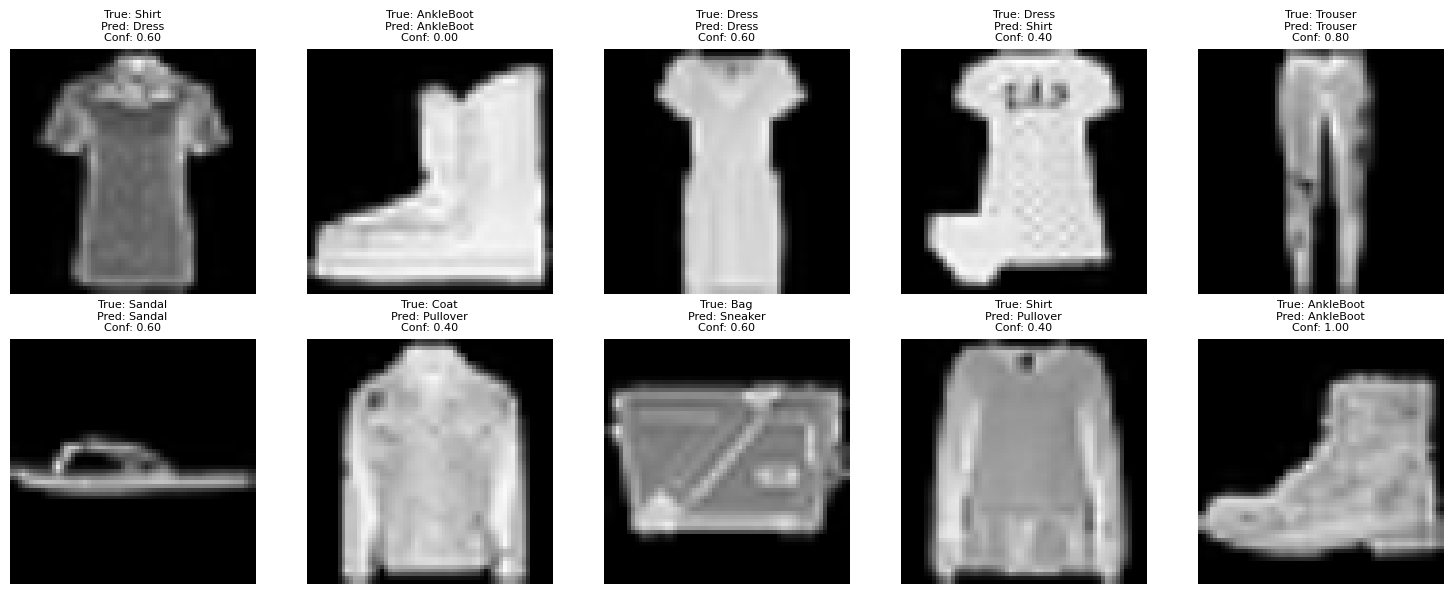

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

n = 10
sample_df = merged.sample(n)

fig, axes = plt.subplots(2, n//2, figsize=(15, 6))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    try:
        img = Image.open(row["path"]).convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"True: {row['true_label']}\n"
            f"Pred: {row['pred_label']}\n"
            f"Conf: {row['confidence']:.2f}",
            fontsize=8
        )
    except Exception as e:
        ax.set_title(f"Error: {e}", fontsize=6)
        ax.axis("off")

plt.tight_layout()
plt.show()


# Extract embeddings

In [3]:
from embedding.extract import EmbeddingExtractor
import numpy as np

extractor = EmbeddingExtractor(backbone="resnet18")
embeddings, ids = extractor.extract_embeddings(image_paths, batch_size=16)
extractor.save_embeddings(embeddings, ids, output_dir="outputs")

print(f"Extracted embeddings for {len(embeddings)} images.")
print(f"Embedding dimension: {embeddings.shape[1] if embeddings.ndim > 1 else 1}")
print(f"Sample IDs (first 5): {ids[:5]}")

# Optional: attach labels for later analysis
np.save("outputs/labels.npy", np.array(labels))
print("Saved embeddings and labels to outputs/")

Extracting embeddings: 100%|██████████| 200/200 [00:05<00:00, 36.87it/s]

Extracted embeddings for 200 images.
Embedding dimension: 512
Sample IDs (first 5): ['fashionmnist_sample/AnkleBoot/88.png', 'fashionmnist_sample/AnkleBoot/89.png', 'fashionmnist_sample/AnkleBoot/167.png', 'fashionmnist_sample/AnkleBoot/198.png', 'fashionmnist_sample/AnkleBoot/15.png']
Saved embeddings and labels to outputs/


In [4]:
import embedding.indexer 
importlib.reload(embedding.indexer)

from embedding.indexer import (
    build_faiss_index_auto,
    search_faiss,
    find_duplicates_faiss_fast,
    build_knn_graph_fast
)

embeddings = np.load("outputs/embeddings_resnet18.npy")
print("Embeddings shape:", embeddings.shape)

index = build_faiss_index_auto(embeddings)

distances, indices = search_faiss(index, embeddings[:5], k=5)
print("\nNearest neighbors for first image:", indices[0])
print("Similarity scores:", distances[0])

duplicates = find_duplicates_faiss_fast(embeddings, threshold=0.98)
print("\nPotential duplicates (top 5):", duplicates[:5])

sims, idxs = build_knn_graph_fast(embeddings, k=10, out_path="outputs/knn_graph.npy")
print("\nSaved kNN graph with shape:", idxs.shape)

Embeddings shape: (200, 512)
[Auto] Selecting FAISS index for 200 vectors...
[Info] Built index with 200 vectors.

Nearest neighbors for first image: [ 0 15  6  9  8]
Similarity scores: [0.9999999  0.8524017  0.84575677 0.8408755  0.83945554]

Potential duplicates (top 5): []

Saved kNN graph with shape: (200, 10)


In [16]:
import embedding.visualize
from embedding.visualize import (
    reduce_embeddings,
    plot_embedding_scatter,
    plot_similarity_heatmap,
    visualize_outliers,
)
importlib.reload(embedding.visualize)
labels = np.load("outputs/labels.npy", allow_pickle=True)
print("\n[Reducing dimensions using UMAP for visualization...]")
reduced_emb = reduce_embeddings(embeddings, method="umap", n_components=2)


fig1 = plot_embedding_scatter(
    reduced_emb,
    labels=labels,
    title="Embedding Space Projection (UMAP)"
)
fig1.show()

fig2 = plot_similarity_heatmap(embeddings, labels)
fig2.show()

outlier_scores = np.random.rand(len(embeddings))
fig3 = visualize_outliers(reduced_emb, outlier_scores)
fig3.show()



[Reducing dimensions using UMAP for visualization...]
[Reducing] Method=umap, Components=2


/Users/debarpita/des646_project-1/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

